### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scienceplots
#import cmasher as cmr
import cmyt

In [2]:
plt.style.use('science')
_params = {
    'figure.figsize':(5,5),
    #'figure.figsize':(6.47,4), # golden ratio
    'figure.dpi':150,
    'font.family':'sans-serif',
    'font.size':11,
    'savefig.format':'png',
    'savefig.transparent':True,
    'xtick.direction':'in',
    'xtick.top':True,
    'ytick.direction':'in',
    'ytick.right':True,
    'errorbar.capsize':3,
    'legend.loc':'upper right',
    'legend.frameon':True,
    'legend.fontsize':9,
    #'axes.axisbelow':True,
}
plt.rcParams.update(_params)


### functions

In [3]:
def error_absdiff(X, Y, eX, eY):
    # metric:
    # m = (X-Y)/abs(X)
    # e(m) = sqrt( (dm/dX e(X))^2 + (dm/dY e(Y))^2 )
    #      = sqrt( ( XY/abs(X)^3 * e(X))^2 + (e(Y)/abs(X))^2 )
    return np.hypot(X*Y*eX/np.abs(X)**3, eY/np.abs(X))

### files

In [37]:
#PROFILE_PATH = 'Rv08-30/'
PROFILE_PATH = 'Rv07-30/'

In [38]:
zmin, zmax = 0.1, 0.6
dz = 0.05
nz = int((zmax-zmin)/dz)
zrange = np.linspace(zmin, zmax, nz+1)

In [39]:
GRAV = ['GR', 'fR']
REDSHIFT = [f'0{100*zrange[i]:1.0f}-0{100*zrange[i+1]:1.0f}' for i in range(nz)]
VOIDTYPE = ['S', 'R']

In [40]:
#MISSING_Z = ['030-035', '035-040', '040-045', '045-050']
MISSING_Z = []

In [42]:
Sigma = {}
DSigma_t = {}
DSigma_x = {}

covS = {}
covDSt = {}
covDSx = {}

R = {}

Nvoids = {}

for g in GRAV:
    Sigma[g] = {}
    DSigma_t[g] = {}
    DSigma_x[g] = {}
    
    covS[g] = {}
    covDSt[g] = {}
    covDSx[g] = {}

    R[g] = {}
    Nvoids[g] = {}
    
    for z in REDSHIFT:
        if z in MISSING_Z: continue
        Sigma[g][z] = {}
        DSigma_t[g][z] = {}
        DSigma_x[g][z] = {}
        
        covS[g][z] = {}
        covDSt[g][z] = {}
        covDSx[g][z] = {}

        R[g][z] = {}
        Nvoids[g][z] = {}
        
        for t in VOIDTYPE:
            filename = PROFILE_PATH+f'lensing_fullsource-{g}_L09_{PROFILE_PATH[:-1]}_z{z}_type{t}_binlin.fits'
            #filename = PROFILE_PATH+f'lensing_{g}_L09_{PROFILE_PATH[:-1]}_z{z}_type{t}_binlin.fits'
            try:
                with fits.open(filename) as f:
                    R[g][z][t] = np.linspace(f[0].header['RIN'],f[0].header['ROUT'],f[0].header['N'])
                    Nvoids[g][z][t] = f[0].header['NVOIDS']
                    
                    Sigma[g][z][t] = f[1].data.Sigma

                    if PROFILE_PATH=='Rv08-30/':
                        if z in ['050-055', '055-060']:
                            DSigma_t[g][z][t] = -f[1].data.DSigma_t
                            DSigma_x[g][z][t] = -f[1].data.DSigma_x
                        else:
                            DSigma_t[g][z][t] = f[1].data.DSigma_t
                            DSigma_x[g][z][t] = f[1].data.DSigma_x
                    else:
                        DSigma_t[g][z][t] = f[1].data.DSigma_t
                        DSigma_x[g][z][t] = f[1].data.DSigma_x

                    covS[g][z][t] = f[2].data
                    covDSt[g][z][t] = f[3].data
                    covDSx[g][z][t] = f[4].data    
            except FileNotFoundError:
                print(f"file '{filename}' not found")
                continue

### plots

#### check

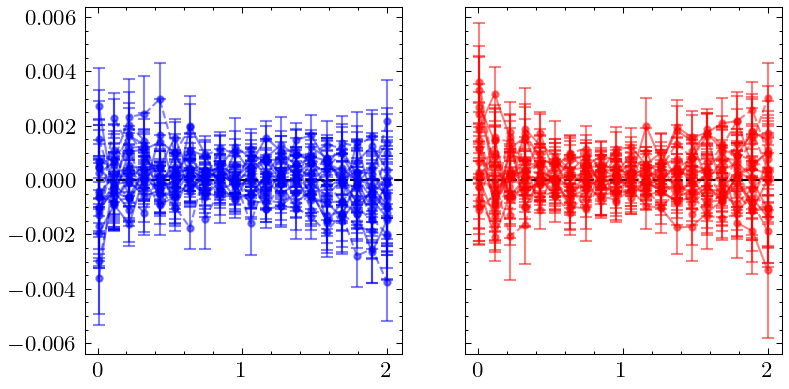

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3), sharex=True, sharey=True)

for z in REDSHIFT:
    for t in VOIDTYPE:
        try:
            ax1.errorbar(R['GR'][z][t], DSigma_x['GR'][z][t], np.sqrt(np.diag(covDSx['GR'][z][t])), c='b', alpha=0.5, fmt='.-' if t=='S' else '.--')
            ax2.errorbar(R['fR'][z][t], DSigma_x['fR'][z][t], np.sqrt(np.diag(covDSx['fR'][z][t])), c='r', alpha=0.5, fmt='.-' if t=='S' else '.--')
        except:
            continue

ax1.axhline(0,ls='--', c='k')
ax2.axhline(0,ls='--', c='k')

#### else

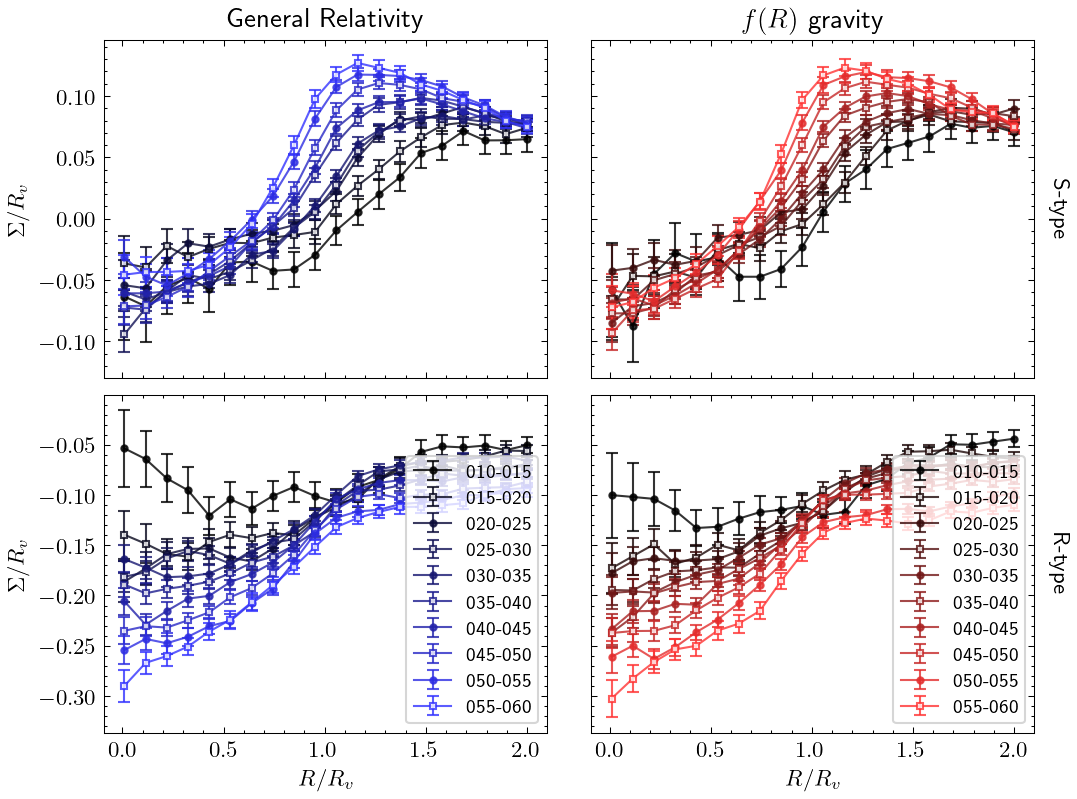

In [44]:
n = 10
colors = {
    'GR':plt.get_cmap('cmyt.pixel_blue', n),
    'fR':plt.get_cmap('cmyt.pixel_red', n),
}

fig, axes = plt.subplots(2,2, figsize=(8,6),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

#for ax in axes.flatten():
#    ax.grid(True, which='both')

for j, g in enumerate(GRAV):
    for i, z in enumerate(REDSHIFT):
        if z in MISSING_Z: continue
        
        for k, t in enumerate(VOIDTYPE):    
            axes[k,j].errorbar(
                R[g][z][t], 
                Sigma[g][z][t],
                np.sqrt(np.diag(covS[g][z][t])),
                fmt='-', marker='o' if i%2==0 else 's',
                markersize=3,
                markerfacecolor='w' if i%2==1 else None,
                c=colors[g](i),
                label=z,
                alpha=0.8
            )

for ax in axes[1,:]:
    ax.set_xlabel('$R/R_v$')
    ax.legend(loc='lower right')

for ax in axes[:,0]:
    ax.set_ylabel('$\Sigma/R_v$')

axes[0,0].set_title('General Relativity')
axes[0,1].set_title('$f(R)$ gravity')

for i, ax in enumerate(axes[:,1]):
    ax.text(1.08, 0.5, "R-type" if i==1 else 'S-type',
        transform=ax.transAxes,
        ha='right',
        va='center',
        rotation=-90.0,
        fontsize=11
    )

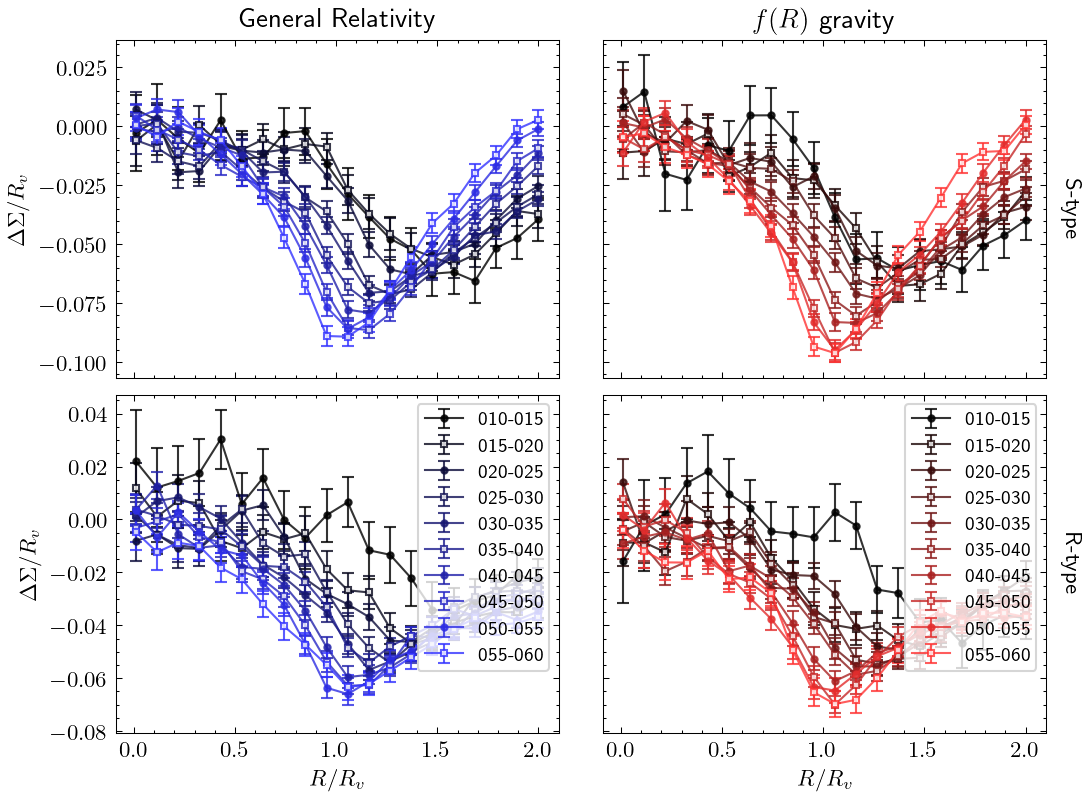

In [45]:
n = 10
colors = {
    'GR':plt.get_cmap('cmyt.pixel_blue', n),
    'fR':plt.get_cmap('cmyt.pixel_red', n),
}

fig, axes = plt.subplots(2,2, figsize=(8,6),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

#for ax in axes.flatten():
#    ax.grid(True, which='both')

for j, g in enumerate(GRAV):
    for i, z in enumerate(REDSHIFT):
        if z in MISSING_Z: continue
        
        for k, t in enumerate(VOIDTYPE):    
            axes[k,j].errorbar(
                R[g][z][t], 
                DSigma_t[g][z][t],
                np.sqrt(np.diag(covDSt[g][z][t])),
                fmt='-', marker='o' if i%2==0 else 's',
                markersize=3,
                markerfacecolor='w' if i%2==1 else None,
                c=colors[g](i),
                label=z,
                alpha=0.8
            )

for ax in axes[1,:]:
    ax.set_xlabel('$R/R_v$')
    ax.legend(loc='upper right')

for ax in axes[:,0]:
    ax.set_ylabel('$\Delta\Sigma/R_v$')

axes[0,0].set_title('General Relativity')
axes[0,1].set_title('$f(R)$ gravity')

for i, ax in enumerate(axes[:,1]):
    ax.text(1.08, 0.5, "R-type" if i==1 else 'S-type',
        transform=ax.transAxes,
        ha='right',
        va='center',
        rotation=-90.0,
        fontsize=11
    )

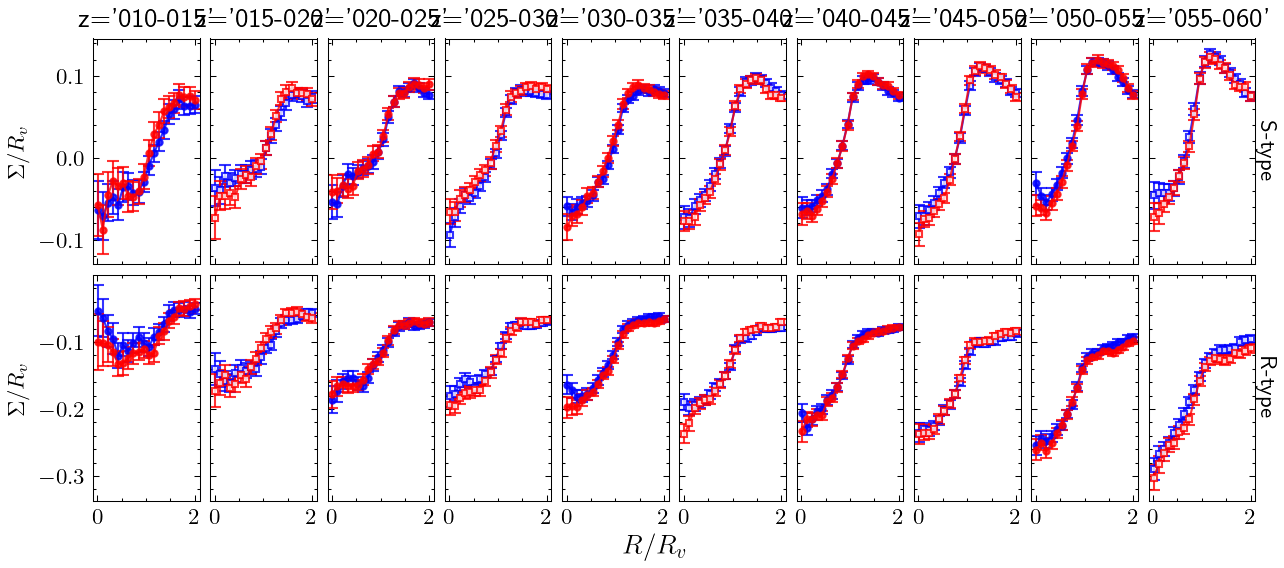

In [46]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,4),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
for j, g in enumerate(GRAV):
    i = 0
    for _, z in enumerate(REDSHIFT):
        if z in MISSING_Z: continue
        
        for k, t in enumerate(VOIDTYPE):    
            axes[k, i].errorbar(
                R[g][z][t], 
                Sigma[g][z][t],
                np.sqrt(np.diag(covS[g][z][t])),
                fmt='-', marker='o' if i%2==0 else 's',
                markersize=3,
                markerfacecolor='w' if i%2==1 else None,
                c='r' if g=='fR' else 'b',
                label=z,
                alpha=0.8
            )
        axes[0, i].set_title(f'{z=}')    
        i+=1
    

        
fig.supxlabel('$R/R_v$')

for ax in axes[:,0]:
    ax.set_ylabel('$\Sigma/R_v$')

#axes[0,0].set_title('General Relativity')
#axes[0,1].set_title('$f(R)$ gravity')

for i, ax in enumerate(axes[:,-1]):
    ax.text(1.2, 0.5, "R-type" if i==1 else 'S-type',
        transform=ax.transAxes,
        ha='right',
        va='center',
        rotation=-90.0,
        fontsize=11
    )

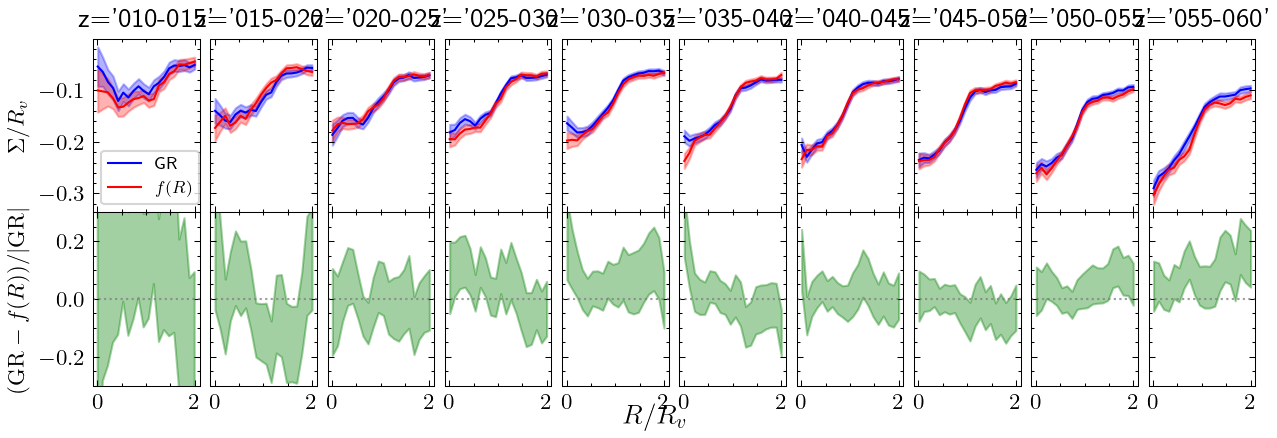

In [47]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,3),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.0)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
t = 'R'
i = 0 
for _, z in enumerate(REDSHIFT):
    if z in MISSING_Z: continue
    for j, g in enumerate(GRAV):
        #for k, t in enumerate(voidtype):    
        axes[1, i].axhline(0.0, ls=':', c='gray', alpha=0.5)
        
        axes[0, i].plot(
            R[g][z][t], 
            Sigma[g][z][t],
            color='r' if g=='fR' else 'b',
            #label=z,
        )
        
        axes[0, i].fill_between(
            R[g][z][t], 
            Sigma[g][z][t] - np.sqrt(np.diag(covS[g][z][t])),
            Sigma[g][z][t] + np.sqrt(np.diag(covS[g][z][t])),
            color='r' if g=='fR' else 'b',
            #label=z,
            alpha=0.3
        )

        midpoints = (Sigma['GR'][z][t] - Sigma['fR'][z][t])/np.abs(Sigma['GR'][z][t])
        errorbars = error_absdiff(
            Sigma['GR'][z][t],
            Sigma['fR'][z][t],
            np.sqrt(np.diag(covS['GR'][z][t])), 
            np.sqrt(np.diag(covS['fR'][z][t]))
        )
        
        axes[1, i].fill_between(
            R['GR'][z][t],
            midpoints - errorbars, 
            midpoints + errorbars, 
            color='g', alpha=0.2
        )
        
        axes[0, i].set_title(f'{z=}')    
    i+=1
        
fig.supxlabel('$R/R_v$')

axes[0,0].set_ylabel('$\Sigma/R_v$')
axes[1,0].set_ylabel('$(\mathrm{GR}-f(R))/|\mathrm{GR}|$')

axes[0,0].plot([],[],label='GR',c='b')
axes[0,0].plot([],[],label='$f(R)$',c='r')
axes[0,0].legend(fontsize=8 ,loc='lower left')

for ax in axes[1,:]:
    ax.set_ylim(-0.3,0.3)

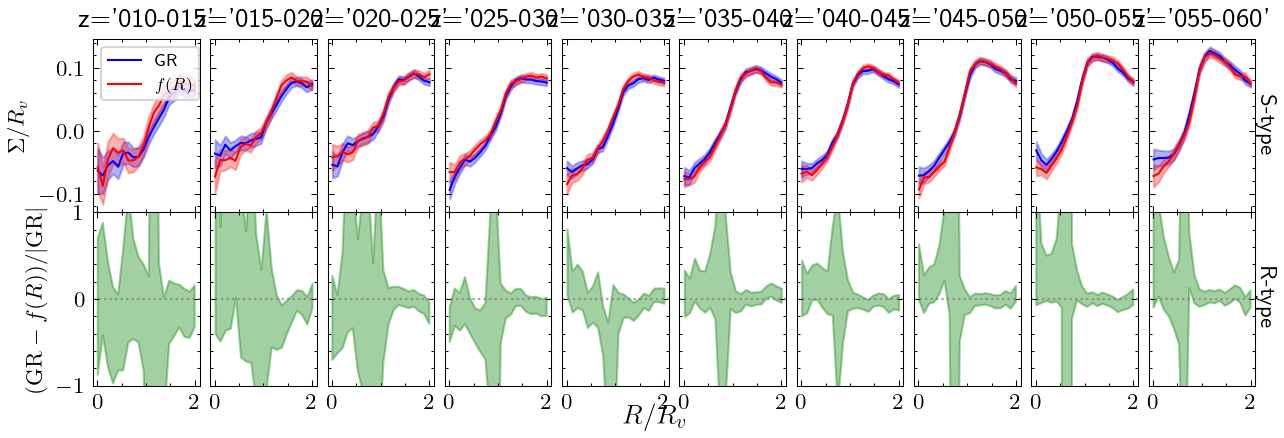

In [48]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,3),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.0)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
t = 'S'
i = 0 
for _, z in enumerate(REDSHIFT):
    if z in MISSING_Z: continue
    for j, g in enumerate(GRAV):
        #for k, t in enumerate(voidtype):    
        axes[1, i].axhline(0.0, ls=':', c='gray', alpha=0.5)
        
        axes[0, i].plot(
            R[g][z][t], 
            Sigma[g][z][t],
            color='r' if g=='fR' else 'b',
            #label=z,
        )
        
        axes[0, i].fill_between(
            R[g][z][t], 
            Sigma[g][z][t] - np.sqrt(np.diag(covS[g][z][t])),
            Sigma[g][z][t] + np.sqrt(np.diag(covS[g][z][t])),
            color='r' if g=='fR' else 'b',
            #label=z,
            alpha=0.3
        )

        midpoints = (Sigma['GR'][z][t] - Sigma['fR'][z][t])/np.abs(Sigma['GR'][z][t])
        errorbars = error_absdiff(
            Sigma['GR'][z][t],
            Sigma['fR'][z][t],
            np.sqrt(np.diag(covS['GR'][z][t])), 
            np.sqrt(np.diag(covS['fR'][z][t]))
        )
        
        axes[1, i].fill_between(
            R['GR'][z][t],
            midpoints - errorbars, 
            midpoints + errorbars, 
            color='g', alpha=0.2
        )
        
        axes[0, i].set_title(f'{z=}')    
    i+=1
        
fig.supxlabel('$R/R_v$')

axes[0,0].set_ylabel('$\Sigma/R_v$')
axes[1,0].set_ylabel('$(\mathrm{GR}-f(R))/|\mathrm{GR}|$')

axes[0,0].plot([],[],label='GR',c='b')
axes[0,0].plot([],[],label='$f(R)$',c='r')
axes[0,0].legend(fontsize=8 ,loc='upper left')

for i, ax in enumerate(axes[:,-1]):
    ax.text(1.2, 0.5, "R-type" if i==1 else 'S-type',
        transform=ax.transAxes,
        ha='right',
        va='center',
        rotation=-90.0,
        fontsize=11
    )

for ax in axes[1,:]:
    ax.set_ylim(-1,1)

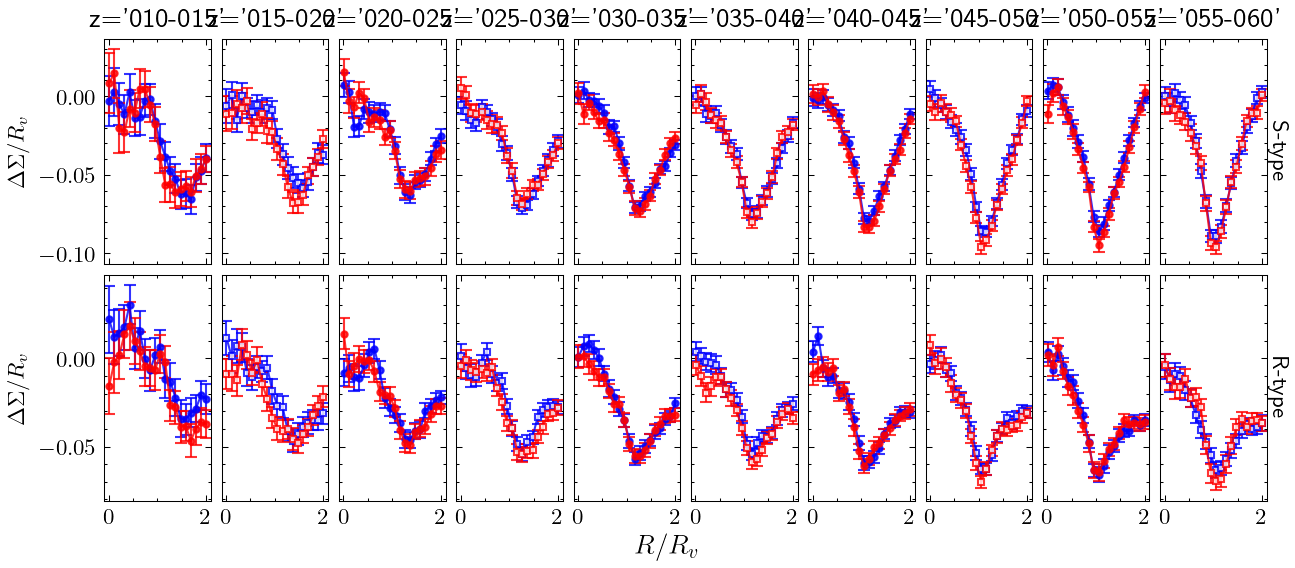

In [49]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,4),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
for j, g in enumerate(GRAV):
    i = 0
    for _, z in enumerate(REDSHIFT):
        if z in MISSING_Z: continue
        
        for k, t in enumerate(VOIDTYPE):    
            axes[k, i].errorbar(
                R[g][z][t], 
                DSigma_t[g][z][t],
                np.sqrt(np.diag(covDSt[g][z][t])),
                fmt='-', marker='o' if i%2==0 else 's',
                markersize=3,
                markerfacecolor='w' if i%2==1 else None,
                c='r' if g=='fR' else 'b',
                #label=z,
                alpha=0.8
            )
        axes[0, i].set_title(f'{z=}')    
        i+=1
    

fig.supxlabel('$R/R_v$')

for ax in axes[:,0]:
    ax.set_ylabel('$\Delta \Sigma/R_v$')

for i, ax in enumerate(axes[:,-1]):
    ax.text(1.2, 0.5, "R-type" if i==1 else 'S-type',
        transform=ax.transAxes,
        ha='right',
        va='center',
        rotation=-90.0,
        fontsize=11
    )

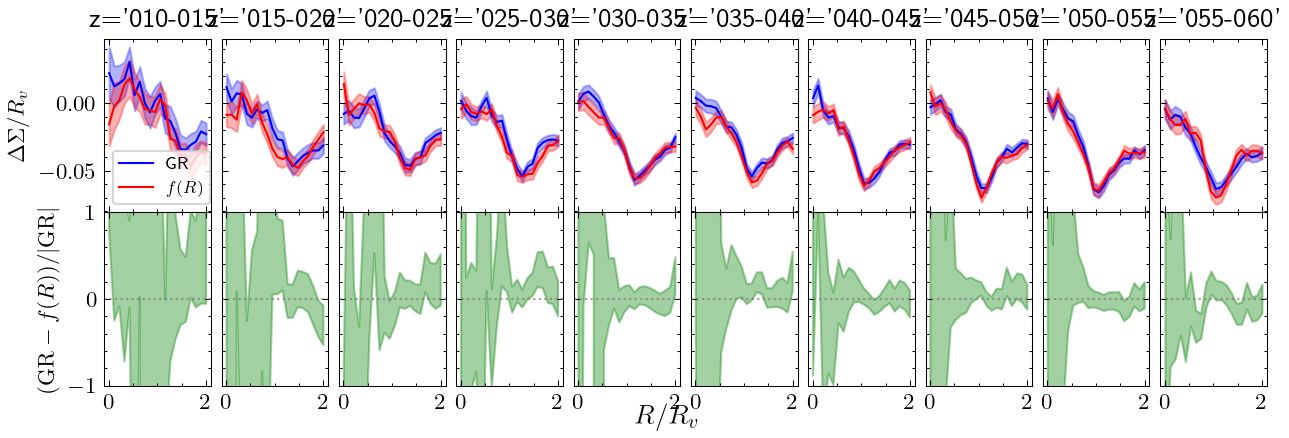

In [50]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,3),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.0)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
t = 'R'
i = 0 
for _, z in enumerate(REDSHIFT):
    if z in MISSING_Z: continue
    for j, g in enumerate(GRAV):
        #for k, t in enumerate(voidtype):    
        axes[1, i].axhline(0.0, ls=':', c='gray', alpha=0.5)
        
        axes[0, i].plot(
            R[g][z][t], 
            DSigma_t[g][z][t],
            color='r' if g=='fR' else 'b',
            #label=z,
        )
        
        axes[0, i].fill_between(
            R[g][z][t], 
            DSigma_t[g][z][t] - np.sqrt(np.diag(covDSt[g][z][t])),
            DSigma_t[g][z][t] + np.sqrt(np.diag(covDSt[g][z][t])),
            color='r' if g=='fR' else 'b',
            #label=z,
            alpha=0.3
        )

        midpoints = (DSigma_t['GR'][z][t] - DSigma_t['fR'][z][t])/np.abs(DSigma_t['GR'][z][t])
        errorbars = error_absdiff(
            DSigma_t['GR'][z][t],
            DSigma_t['fR'][z][t],
            np.sqrt(np.diag(covDSt['GR'][z][t])), 
            np.sqrt(np.diag(covDSt['fR'][z][t]))
        )
        
        axes[1, i].fill_between(
            R['GR'][z][t],
            midpoints - errorbars, 
            midpoints + errorbars, 
            color='g', alpha=0.2
        )
        
        axes[0, i].set_title(f'{z=}')    
    i+=1
        
fig.supxlabel('$R/R_v$')

axes[0,0].set_ylabel('$\Delta\Sigma/R_v$')
axes[1,0].set_ylabel('$(\mathrm{GR}-f(R))/|\mathrm{GR}|$')

axes[0,0].plot([],[],label='GR',c='b')
axes[0,0].plot([],[],label='$f(R)$',c='r')
axes[0,0].legend(fontsize=8 ,loc='lower left')

for ax in axes[1,:]:
    ax.set_ylim(-1,1)

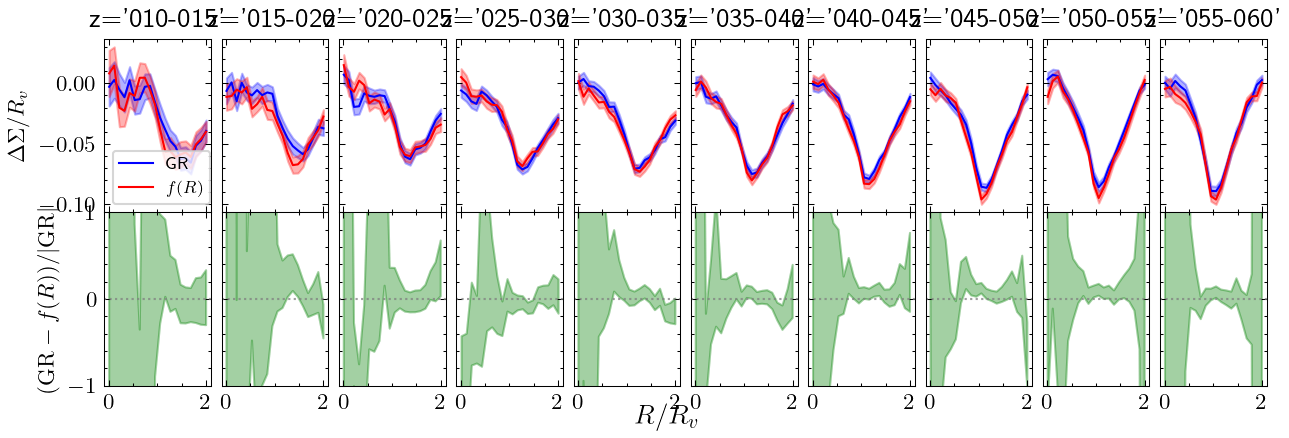

In [51]:
fig, axes = plt.subplots(2, len(REDSHIFT)-len(MISSING_Z), figsize=(10,3),
                              sharex=True, sharey='row')

fig.subplots_adjust(wspace=0.1, hspace=0.0)

#for ax in axes.flatten():
#    ax.grid(True, which='both')
t = 'S'
i = 0 
for _, z in enumerate(REDSHIFT):
    if z in MISSING_Z: continue
    for j, g in enumerate(GRAV):
        #for k, t in enumerate(voidtype):    
        axes[1, i].axhline(0.0, ls=':', c='gray', alpha=0.5)
        
        axes[0, i].plot(
            R[g][z][t], 
            DSigma_t[g][z][t],
            color='r' if g=='fR' else 'b',
            #label=z,
        )
        
        axes[0, i].fill_between(
            R[g][z][t], 
            DSigma_t[g][z][t] - np.sqrt(np.diag(covDSt[g][z][t])),
            DSigma_t[g][z][t] + np.sqrt(np.diag(covDSt[g][z][t])),
            color='r' if g=='fR' else 'b',
            #label=z,
            alpha=0.3
        )

        midpoints = (DSigma_t['GR'][z][t] - DSigma_t['fR'][z][t])/np.abs(DSigma_t['GR'][z][t])
        errorbars = error_absdiff(
            DSigma_t['GR'][z][t],
            DSigma_t['fR'][z][t],
            np.sqrt(np.diag(covDSt['GR'][z][t])), 
            np.sqrt(np.diag(covDSt['fR'][z][t]))
        )
        
        axes[1, i].fill_between(
            R['GR'][z][t],
            midpoints - errorbars, 
            midpoints + errorbars, 
            color='g', alpha=0.2
        )
        
        axes[0, i].set_title(f'{z=}')    
    i+=1
        
fig.supxlabel('$R/R_v$')

axes[0,0].set_ylabel('$\Delta\Sigma/R_v$')
axes[1,0].set_ylabel('$(\mathrm{GR}-f(R))/|\mathrm{GR}|$')

axes[0,0].plot([],[],label='GR',c='b')
axes[0,0].plot([],[],label='$f(R)$',c='r')
axes[0,0].legend(fontsize=8 ,loc='lower left')

for ax in axes[1,:]:
    ax.set_ylim(-1,1)